# **Notebook 3**
## **Feature Management**

### Introduction
This notebook executes the core **Feature Engineering** phase by performing two critical operations: splitting the data and applying statistical transformations in a controlled, non-leaking sequence. Since we are **not using a Scikit-learn Pipeline**, all transformation steps (Imputation, Scaling, Encoding) must be manually fitted and applied.

### Anti-Leakage Protocol: Split First
1.  **Split Data First:** The structurally cleaned dataset is first divided into dedicated Training, Validation, and Test sets.
2.  **Fit on Training Only:** All statistical transformers (`SimpleImputer`, `StandardScaler`, `OneHotEncoder`) are then **fitted exclusively on the Training set**.
3.  **Transform All:** The parameters learned solely from the Training set are applied to transform the Training, Validation, and Test sets.

This explicit, manual sequencing guarantees that no information from the Test or Validation set contaminates the Training process.

### Objectives
The objectives are:
* **Data Splitting:** Divide the dataset into 60% Training, 20% Validation, and 20% Test sets using a stratified approach to maintain class balance (`OK`/`KO`) in all partitions.
* **Imputation:** Manually fit and transform the data, filling missing values in numerical features using the median calculated only from the Training data.
* **Scaling:** Manually fit and transform the numerical features using the `StandardScaler`, with its mean ($\mu$) and standard deviation ($\sigma$) calculated only from the Training data.
* **Encoding:** Manually fit and transform the categorical feature (`origin`) using `OneHotEncoder` based only on the unique categories present in the Training data.
* **Export:** Save the fully transformed data splits and the fitted transformer objects for direct use by the **Modelling (NB4)** and **Final Model (NB9)** notebooks.

In [1]:
import pandas as pd
import numpy as np
import pickle, os

# data partition
from sklearn.model_selection import train_test_split, StratifiedKFold 

# imputação
from sklearn.impute import SimpleImputer # <-- ESSENCIAL para imputação manual

# scaling methods
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import scipy.stats as stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

##### **3.1 Load Structurally Cleaned Data from NB2**

In [2]:
learn_clean = pd.read_csv('datasetlearn_structurally_cleaned.csv', sep = ',')
display(learn_clean.shape)
learn_clean.head()

(5200, 15)

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,origin,oven_temperature,preheating_time,salt_ratio,sugar_content,vanilla_extract,quality_class_binary
0,54.0,24.0,26.0,100.4,52.0,11.0,309.0,3.2,Lisboa,NaN,207.0,42.74,22.8,5.7,0.0
1,66.0,37.0,34.0,98.0,46.0,10.0,317.0,3.3,Lisboa,306.0,245.0,41.73,11.6,4.0,0.0
2,41.0,30.0,19.0,99.3,53.0,10.0,130.0,3.4,Porto,121.0,186.0,75.10,20.3,7.5,1.0
3,62.0,24.0,48.0,98.0,115.0,9.0,354.0,3.3,Lisboa,357.0,186.0,46.41,73.3,4.2,1.0
4,55.0,21.0,34.0,100.1,48.0,9.0,211.0,3.0,Lisboa,202.0,218.0,56.52,80.1,6.0,0.0


Drop rows where the target variable is null, due to reasons, one in the code and one logic. The one in the code is the stratify=y cannot process them, and the logic one is that either the Pastel de Nata is Ok or not Ok, can't be NaN

In [3]:
learn_clean = learn_clean.dropna(subset=['quality_class_binary'])

### **Feature Engineering** (tb ns se é aqui)

In [4]:
#learn_clean['total_heat'] = learn_clean['baking_duration'] * learn_clean['oven_temperature']
learn_clean['temp_shock'] = learn_clean['oven_temperature'] / learn_clean['baking_duration']
learn_clean['sugar_fat_ratio'] = learn_clean['sugar_content'] / learn_clean['cream_fat_content']
learn_clean['total_time'] = learn_clean['cooling_period'] + learn_clean['baking_duration']
learn_clean['baking_intensity'] = learn_clean['final_temperature'] * learn_clean['baking_duration']
learn_clean['temp_shock2'] = learn_clean['oven_temperature'] - learn_clean['egg_temperature']

#### **3.2 Data Partitioning**

Separate features (X) and the binary target (y)

In [5]:
X = learn_clean.drop('quality_class_binary',axis = 1)
y = learn_clean['quality_class_binary']

In [6]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size = 0.7,shuffle = True, random_state=42, stratify=y)

This will create two different datasets, one for train (70% of the data) and one for test (30% of the data). <br>
`shuffle` randomizes the order of the observations, and `stratify` makes it so that every dataset resulting from the split has the same proportion of each label of the dependent variable.

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle = True, random_state=42, stratify=y_rest)
     

To create three datasets (train, validation and test) with the function train_test_split, the function has to be called twice. <br>
First we are going to create two sets of datasets, one for test (X_test and y_test) and another one that includes the data for training and validation (X_train_val and y_train_val).

Run the cell below to check the proportion of data for each dataset.

In [8]:
print('train:{}% | validation:{}% | test:{}%'.format(round(len(y_train)/len(y),2),
                                                     round(len(y_val)/len(y),2),
                                                     round(len(y_test)/len(y),2)
                                                    ))

train:0.7% | validation:0.15% | test:0.15%


#### **3.3 Load and Structural Clean-up of predict.csv** (nao sei onde isto é)

In [9]:
predict_data = pd.read_csv('Nata_Files/predict.csv', sep = ',', index_col = 0)
#id_predict = predict_data['id'] #to later be eliminated from the predict dataset
predict_data.head()

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,notes_baker,origin,oven_temperature,pastry_type,preheating_time,salt_ratio,sugar_content,vanilla_extract
id,,,,,,,,,,,,,,,,
5201,79.0,22,40,98.6,79.0,9.0,259.0,3.2,NaN,Lisboa,268.0,NaN,208.0,49.63,182.6,4.0
5202,49.0,26,32,101.9,105.0,9.0,287.0,3.2,NaN,Lisboa,287.0,Pastel de nata,189.0,182.54,76.2,4.8
5203,80.0,28,24,96.6,20.0,10.0,64.0,3.4,NaN,Porto,74.0,Pastel Nata,201.0,100.41,23.5,6.1
5204,74.0,21,37,97.2,81.0,9.0,314.0,3.0,NaN,Lisboa,317.0,NaN,220.0,46.66,143.2,4.9
5205,41.0,19,41,97.3,104.0,10.0,246.0,3.2,NaN,Lisboa,243.0,Pastel Nata,191.0,39.45,143.0,7.0


The `predict.csv` data must undergo the same structural cleaning as the training data (NB2) before statistical transformations are applied. This includes saving the required `id` and cleaning categorical text formats.

In [10]:
predict_data = predict_data.drop(columns=[ 'notes_baker', 'pastry_type'])
predict_data['origin'] = predict_data['origin'].replace({
    'lisboa': 'Lisboa', ' lisboa': 'Lisboa', 'lisboa ': 'Lisboa', 'porto': 'Porto', 
    ' porto': 'Porto', 'porto ': 'Porto', 'LISBOA': 'Lisboa', 'PORTO': 'Porto'    
})

In [11]:
#predict_data['total_heat'] = predict_data['baking_duration'] * predict_data['oven_temperature']
predict_data['temp_shock'] = predict_data['oven_temperature'] / predict_data['baking_duration']
predict_data['sugar_fat_ratio'] = predict_data['sugar_content'] / predict_data['cream_fat_content']
predict_data['total_time'] = predict_data['cooling_period'] + predict_data['baking_duration']
predict_data['baking_intensity'] = predict_data['final_temperature'] * predict_data['baking_duration']
predict_data['temp_shock2'] = predict_data['oven_temperature'] - predict_data['egg_temperature']

## **ENCODING TEST**

#### **3.4 Prepare numerical and categorical columns**
Prepare sub-dataframes for ALL sets (Train, Val, Test, Predict).  
This section applies the two primary statistical transformations, Imputation and Scaling, to the numerical features, strictly adhering to the "Fit on Train, Transform on All" principle to prevent data leakage.

In [12]:
numerical_features = X.select_dtypes(include = np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude = np.number).columns.tolist()

Numerical Sub-DataFrames

In [13]:
X_train_num = X_train.select_dtypes(include = np.number)
X_val_num = X_val.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

X_predict_num = predict_data.select_dtypes(include = np.number)

Categorical Sub-DataFrames

In [14]:
X_train_cat = X_train.select_dtypes(exclude = np.number)
X_val_cat = X_val.select_dtypes(exclude = np.number)
X_test_cat = X_test.select_dtypes(exclude = np.number)

X_predict_cat = predict_data.select_dtypes(exclude = np.number)

##### **Encoding (OneHotEncoder)**

This section handles the categorical feature by converting it into a numerical format suitable for Machine Learning algorithms.

In [15]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #if an unseen category appears in the test or prediction data, the encoder will safely ignore it, maintaining the correct column structure.

encoder.fit(X_train_cat)

#Training Data
X_train_cat_encoded = encoder.transform(X_train_cat)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_train_cat.index)

#Validation Data
X_val_cat_encoded = encoder.transform(X_val_cat)
X_val_cat_encoded = pd.DataFrame(X_val_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_val_cat.index)

#Testing Data
X_test_cat_encoded = encoder.transform(X_test_cat)  
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_test_cat.index)

#Prediction Data
X_predict_cat_encoded = encoder.transform(X_predict_cat)
X_predict_cat_encoded = pd.DataFrame(X_predict_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_predict_cat.index)

#### **3.5 Fit and transform numerical features (Imputation, Capping, Scaling)**

##### **Imputation (Handling NaNs)**

In [16]:
imputer = SimpleImputer(strategy='median')

The `SimpleImputer` with a `median` strategy is used to fill missing values (`NaNs`). The median is chosen because it is robust to outliers, which helps avoid distorting the feature distributions.

In [17]:
imputer.fit(X_train_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


The `imputer` is **fitted ONLY on the `X_train_num`** data. This calculates the median for each numerical column exclusively using the training set's knowledge.

In [18]:
# Transform all splits using the median learned from the training data
X_train_num.loc[:, :] = imputer.transform(X_train_num) 
X_val_num.loc[:, :] = imputer.transform(X_val_num)
X_test_num.loc[:, :] = imputer.transform(X_test_num)

X_predict_num.loc[:, :] = imputer.transform(X_predict_num)

This median is then applied (`.transform()`) to `X_train_num`, `X_val_num`,`X_test_num` and `X_predict_num`, ensuring that the Val/Test/Predict sets are treated as unseen data.

##### **Leading with outliers** (provavelmente temos de fazer alguma coisa idferete9)

In [19]:
"""
outlier_bounds = {}

for col in X_train_num.columns:
    # Calculate Bounds (FIT ONLY ON TRAIN)
    Q1 = X_train_num[col].quantile(0.25)
    Q3 = X_train_num[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    outlier_bounds[col] = {'upper': upper_bound, 'lower': lower_bound}
"""    

"\noutlier_bounds = {}\n\nfor col in X_train_num.columns:\n    # Calculate Bounds (FIT ONLY ON TRAIN)\n    Q1 = X_train_num[col].quantile(0.25)\n    Q3 = X_train_num[col].quantile(0.75)\n    IQR = Q3 - Q1\n    upper_bound = Q3 + 1.5 * IQR\n    lower_bound = Q1 - 1.5 * IQR\n    outlier_bounds[col] = {'upper': upper_bound, 'lower': lower_bound}\n"

Calculate the statistical thresholds used to identify and potentially cap outliers in the numerical features. This calculation is performed only on the training data.  

By performing these calculations exclusively on `X_train_num`, we ensure that the limits defined for treating outliers (the upper_bound and lower_bound) are derived solely from the information available during the model's training phase.

In [20]:
"""
for data_num in [X_train_num, X_val_num, X_test_num, X_predict_num]:
        data_num[col] = np.where(data_num[col] > upper_bound, upper_bound, data_num[col])
        data_num[col] = np.where(data_num[col] < lower_bound, lower_bound, data_num[col])
"""

'\nfor data_num in [X_train_num, X_val_num, X_test_num, X_predict_num]:\n        data_num[col] = np.where(data_num[col] > upper_bound, upper_bound, data_num[col])\n        data_num[col] = np.where(data_num[col] < lower_bound, lower_bound, data_num[col])\n'

Capping (Transform All): The calculated `upper_bound` and `lower_bound` are then applied to cap the extreme values in the Training, Validation,Test and Predict sets. This guarantees that the validation, test and predict data are treated using rules derived only from the training distribution.

In [21]:

if 'oven_temperature' in X_train_num.columns:
    X_train_num['oven_temperature'] = X_train_num['oven_temperature'].clip(lower=0, upper=350)

# Sugar: Can't be more than 100% (100g/100g).
if 'sugar_content' in X_train_num.columns:
    X_train_num['sugar_content'] = X_train_num['sugar_content'].clip(lower=0, upper=100)

# Salt Ratio: Usually 0-50g. High values are errors.
# Note: Check if your column is named 'salt ratio' or 'salt_ratio'
if 'salt ratio' in X_train_num.columns:
    X_train_num['salt ratio'] = X_train_num['salt ratio'].clip(lower=0, upper=50)
elif 'salt_ratio' in X_train_num.columns:
    X_train_num['salt_ratio'] = X_train_num['salt_ratio'].clip(lower=0, upper=50)

# Egg Temp: Can't be boiling (100°C) or absolute zero.
if 'egg-temperature' in X_train_num.columns:
    X_train_num['egg-temperature'] = X_train_num['egg-temperature'].clip(lower=0, upper=60) 

# 2. Missing Value Imputation (Global Median)
# We use median because it ignores the extreme values we just capped.
features_to_impute = ['baking duration', 'cooling_period', 'oven_temperature']

for col in features_to_impute:
    if col in X_train_num.columns:
        median_val = X_train_num[col].median()
        X_train_num[col] = X_train_num[col].fillna(median_val)
        print(f"Imputed {col} with median: {median_val}")

# 3. Verify No NaNs remain
print("Remaining Nulls:", X_train_num.isnull().sum().sum())


Imputed cooling_period with median: 31.0
Imputed oven_temperature with median: 229.0
Remaining Nulls: 0


##### **Scaling**

In [22]:
scaler = RobustScaler()
#Fitting the scaler on the training data
scaler.fit(X_train_num)

#Transforming training data
X_train_scaled = scaler.transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_features, index = X_train_num.index)

#Transforming validation data
X_val_scaled = scaler.transform(X_val_num)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = numerical_features, index = X_val_num.index)

#Transforming testing data
X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = numerical_features, index = X_test_num.index)

#Transforming prediction data
X_predict_scaled = scaler.transform(X_predict_num[numerical_features])
X_predict_scaled = pd.DataFrame(X_predict_scaled, columns = numerical_features, index = X_predict_num.index)

We use the `StandardScaler` to standardize the numerical features. This process transforms the data such that it has a mean ($\mu$) of zero and a standard deviation ($\sigma$) of one. This is crucial for models that rely on distance metrics (like K-Nearest Neighbors) or gradient descent optimization (like Neural Networks).

## **Feature Selection** (nao sei se é aqui)

## Filter Methods

In [23]:
X_train_scaled.var().sort_values()

sugar_content        0.284467
ambient_humidity     0.338219
salt_ratio           0.438384
temp_shock           0.439754
oven_temperature     0.496271
final_temperature    0.514154
egg_temperature      0.514358
temp_shock2          0.540945
cream_fat_content    0.548003
sugar_fat_ratio      0.571732
baking_intensity     0.610869
lemon_zest_ph        0.690131
total_time           0.735223
vanilla_extract      0.764231
baking_duration      0.860913
preheating_time      0.997719
cooling_period       1.073395
egg_yolk_count       1.548949
dtype: float64

All the variables have non-zero variance, indicating diversity.....

### Spearman's correlation analysis

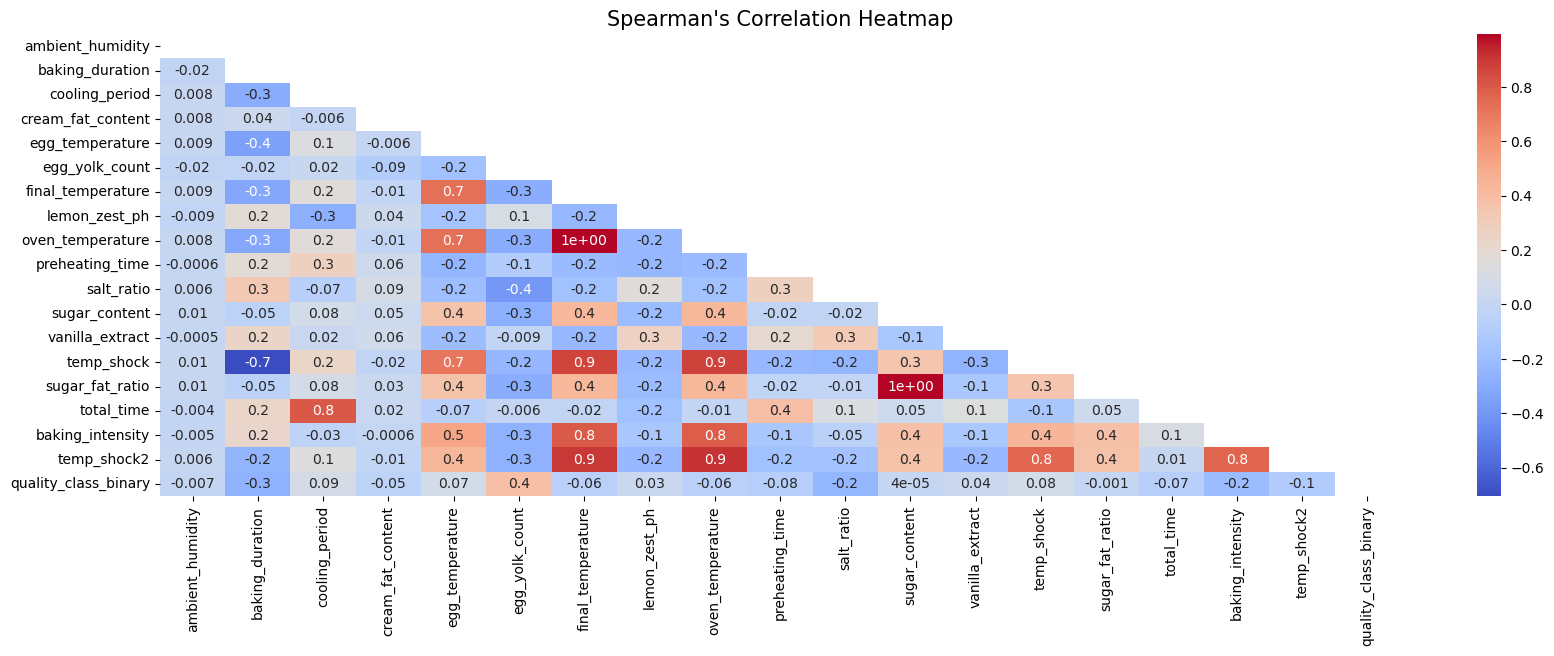

In [24]:
all_train_numerical = X_train_scaled.join(y_train)

# Computing Spearman's Correlation
correlation = all_train_numerical.corr(method = 'spearman')

# Plotting the lower triangle of the correlation map
def corr_heatmap(correlation):
    plt.figure(figsize=(20, 6))
    ax = sns.heatmap(data = correlation, annot = True, mask = np.triu(np.ones_like(correlation)), cmap = 'coolwarm', fmt = '.1')
    ax.set_title("Spearman's Correlation Heatmap", fontdict = {'fontsize': 15})
    plt.show()

corr_heatmap(correlation)

### Chi square test

In [25]:
def TestIndependence(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result = "{0} is an IMPORTANT predictor".format(var)
    else:
        result = "{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [26]:
for variable in X_train_cat.columns:
    TestIndependence(X_train_cat[variable], y_train, variable)

origin is an IMPORTANT predictor


We only have one categorical variable and it is important

### Wrapper Methods

In [27]:
model = LogisticRegression()

RFE- recursive Feature Elimination

Optimum number of features

In [28]:
# Number of features
nof_list = np.arange(1,8)
high_score = 0

# Variable to store the optimum features
nof = 0
score_list = []
for n in range(len(nof_list)):
    rfe = RFE(model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_scaled)
    model.fit(X_train_rfe,y_train)

    score = model.score(X_val_rfe,y_val)
    score_list.append(score)

    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 4
Score with 4 features: 0.743590


selecting the features

In [29]:
rfe = RFE(estimator = model, n_features_to_select = nof)
rfe_fitted = rfe.fit_transform(X_train_scaled, y_train)
selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
selected_features

ambient_humidity     False
baking_duration      False
cooling_period       False
cream_fat_content    False
egg_temperature      False
egg_yolk_count        True
final_temperature     True
lemon_zest_ph        False
oven_temperature     False
preheating_time      False
salt_ratio           False
sugar_content        False
vanilla_extract      False
temp_shock            True
sugar_fat_ratio      False
total_time           False
baking_intensity     False
temp_shock2           True
dtype: bool

2. Sequential Forward Selection SFS

In [30]:
"""
# Number of features
nof_list = np.arange(1, min(X_train_scaled.shape[1], 8))
high_score = 0
nof = 0
score_list = []

for n in range(len(nof_list)):
    sfs = SequentialFeatureSelector(model, n_features_to_select = nof_list[n])
    X_train_sfs = sfs.fit_transform(X_train_scaled, y_train)
    X_val_sfs = sfs.transform(X_val_scaled)
    model.fit(X_train_sfs, y_train)

    score = model.score(X_val_sfs, y_val)
    score_list.append(score)

    if score > high_score:
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))
"""

'\n# Number of features\nnof_list = np.arange(1, min(X_train_scaled.shape[1], 8))\nhigh_score = 0\nnof = 0\nscore_list = []\n\nfor n in range(len(nof_list)):\n    sfs = SequentialFeatureSelector(model, n_features_to_select = nof_list[n])\n    X_train_sfs = sfs.fit_transform(X_train_scaled, y_train)\n    X_val_sfs = sfs.transform(X_val_scaled)\n    model.fit(X_train_sfs, y_train)\n\n    score = model.score(X_val_sfs, y_val)\n    score_list.append(score)\n\n    if score > high_score:\n        high_score = score\n        nof = nof_list[n]\n\nprint("Optimum number of features: %d" % nof)\nprint("Score with %d features: %f" % (nof, high_score))\n'

selecting the features

In [31]:
"""
sfs = SequentialFeatureSelector(estimator = model, n_features_to_select = nof)
sfs_fitted = sfs.fit_transform(X_train_scaled, y_train)
selected_features = pd.Series(sfs.support_, index = X_train_scaled.columns)
selected_features

"""

'\nsfs = SequentialFeatureSelector(estimator = model, n_features_to_select = nof)\nsfs_fitted = sfs.fit_transform(X_train_scaled, y_train)\nselected_features = pd.Series(sfs.support_, index = X_train_scaled.columns)\nselected_features\n\n'

3. Embedded Mehods

Lasso Regression

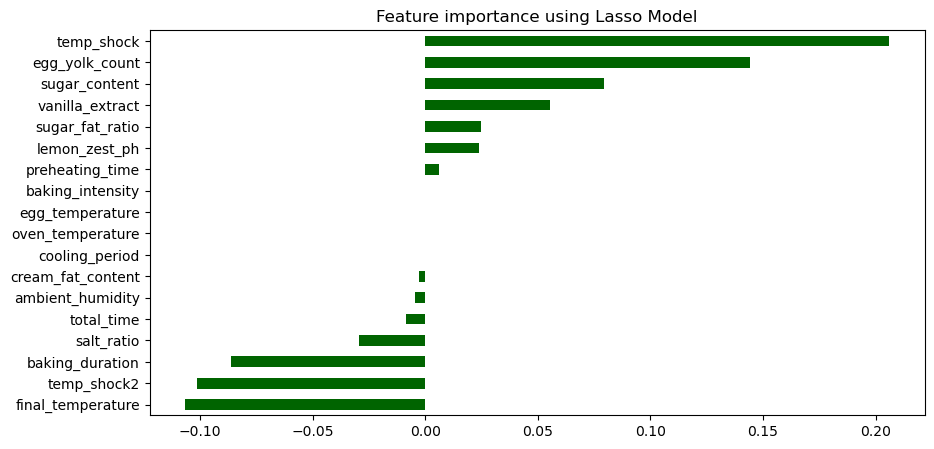

In [32]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize = (10, 5))
    imp_coef.plot(kind = "barh", color = 'darkgreen')
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()

reg.fit(X_train_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_scaled.columns)

plot_importance(coef,'Lasso')

According to Lasso, we should discard the baking intesity, the sugar content, the oven temperature, the total energy and the total heat

<Axes: xlabel='Value', ylabel='Features'>

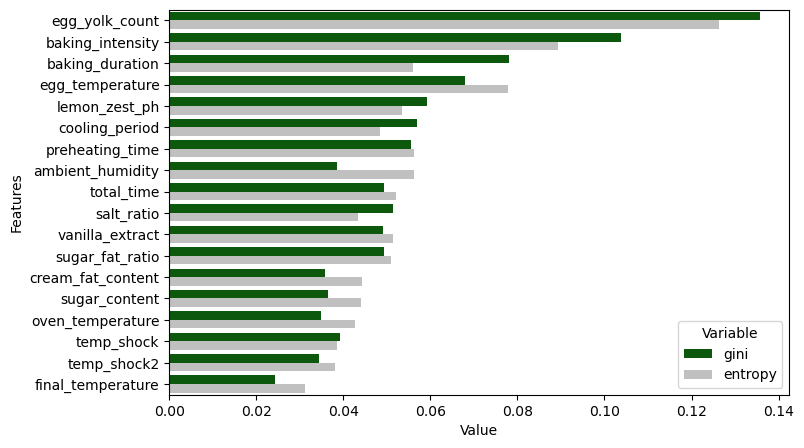

In [33]:
gini_importance = DecisionTreeClassifier(splitter='random', random_state=42).fit(X_train_scaled, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=42).fit(X_train_scaled, y_train).feature_importances_

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns=['gini', 'entropy'])
zippy['Features'] = X_train_scaled.columns
tidy = zippy.melt(id_vars='Features').rename(columns=str.title)
tidy.sort_values(['Value'], ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(y='Features', x='Value', hue='Variable', data=tidy, palette=['darkgreen', 'silver'])

In [34]:
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_num, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
importances = pd.Series(rf_selector.feature_importances_, index=X_train_num.columns)
importances = importances.sort_values(ascending=True)
importances

lemon_zest_ph        0.027894
ambient_humidity     0.040075
sugar_content        0.041994
cream_fat_content    0.043734
oven_temperature     0.043985
total_time           0.046397
final_temperature    0.049565
salt_ratio           0.050419
preheating_time      0.052554
cooling_period       0.052787
temp_shock2          0.056648
vanilla_extract      0.057582
sugar_fat_ratio      0.058803
temp_shock           0.059740
egg_temperature      0.063135
baking_duration      0.071600
baking_intensity     0.074385
egg_yolk_count       0.108704
dtype: float64

In [36]:
#n_drop = 3
#features_to_drop = importances.head(n_drop).index.tolist()
features_to_drop = ['oven_temperature', 'cream_fat_content', 'sugar_content']

print(f"Dropping these features globally: {features_to_drop}")

Dropping these features globally: ['oven_temperature', 'cream_fat_content', 'sugar_content']


In [37]:
# We drop from ALL sets to keep dimensions consistent
X_train_scaled = X_train_scaled.drop(columns=features_to_drop)
X_val_scaled   = X_val_scaled.drop(columns=features_to_drop)
X_test_scaled  = X_test_scaled.drop(columns=features_to_drop)

# Don't forget the prediction set for Kaggle!
X_predict_scaled = X_predict_scaled.drop(columns=features_to_drop)

The 3 least influencial predictors ate total_heat oven_temperature and temp_shock2

### **Final Insights**

| Numerical Data |  Spearman's Correlation | RFE | SFS | Lasso | Decision Tree | Relevance |
| --- | --- | --- | --- | --- | --- | --- |
|  Egg Yolk Count | Discard |  Keep | Keep | Keep | Keep | **Keep** |
|  Baking Duration | Discard |  Keep | Keep | Keep | Keep| **Keep** |
|  Egg temperature | Discard  |  Discard | Keep| Keep | Keep | **Keep** |
|  Baking Intensity | Discard  |  Discard| Keep | Discard | Keep | **Keep** |
|  Lemon PH  | Discard |  Keep | Discard| Keep | Keep | **Keep** |
| Vanilla Extract | Discard|Discard|Discard| Keep|Keep|
| Sugar Fat Ratio | Discard|Discard|Discard|Keep|Keep|
| Salt Ratio | Discard|Discard|Discard|Keep|Keep|
| Ambient Humidity |Discard|Discard|Discard|Keep|Keep|
| Total Time |Discard|Discard|Discard|Keep|Keep|
| Sugar Content |Discard|Discard|Keep| Discard |Keep|
| Pre heating Time |Discard|Discard|Discard|Keep|Keep|
| Cream Fat Content |Discard|Discard|Discard|Keep|Keep|
| Final Temperature |Discard|Discard|Discard|Keep|Keep|
| Cooling Period |Discard|Discard|Discard|Keep|Keep|
| Temp Shock |Discard|Keep|Discard|Keep| Discard|
| Temp Shock 2 |Discard|Keep|Discard|Keep|Discard
| Oven Temperature |Discard|Discard|Discard| Discard| Discard|


VER SE DAMOS DROP OU NO«AO QAQUI

#### **3.6 Final merging and export**

Concatenate transformed features

In [38]:

'''
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_final = pd.concat([X_val_num, X_val_cat_df], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat_df], axis=1)
X_predict_final = pd.concat([X_predict_num, X_predict_cat_df], axis=1)

print(f" X_train_final shape: {X_train_final.shape}")~
'''

'\nX_train_final = pd.concat([X_train_num, X_train_cat], axis=1)\nX_val_final = pd.concat([X_val_num, X_val_cat_df], axis=1)\nX_test_final = pd.concat([X_test_num, X_test_cat_df], axis=1)\nX_predict_final = pd.concat([X_predict_num, X_predict_cat_df], axis=1)\n\nprint(f" X_train_final shape: {X_train_final.shape}")~\n'

In [39]:
feature_names_cat = encoder.get_feature_names_out(categorical_features)

# TRAIN
#X_train_num_df = pd.DataFrame(X_train_scaled, columns=numerical_features).reset_index(drop=True)
#X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=feature_names_cat).reset_index(drop=True)
X_train_final = pd.concat([X_train_scaled, X_train_cat_encoded], axis=1)


# VALIDATION
#X_val_num_df = pd.DataFrame(X_val_scaled, columns=numerical_features).reset_index(drop=True)
#X_val_cat_df = pd.DataFrame(X_val_cat_encoded, columns=feature_names_cat).reset_index(drop=True)
X_val_final = pd.concat([X_val_scaled, X_val_cat_encoded], axis=1)

# TEST
#X_test_num_df = pd.DataFrame(X_test_scaled, columns=numerical_features).reset_index(drop=True)
#X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=feature_names_cat).reset_index(drop=True)
X_test_final = pd.concat([X_test_scaled, X_test_cat_encoded], axis=1)


# PREDICT
#X_predict_num_df = pd.DataFrame(X_predict_scaled, columns=numerical_features).reset_index(drop=True)
#X_predict_cat_df = pd.DataFrame(X_predict_cat_encoded, columns=feature_names_cat).reset_index(drop=True)
X_predict_final = pd.concat([X_predict_scaled, X_predict_cat_encoded], axis=1)

The Python `pickle` library is used to save the entire dictionary (`notebook3_data_fixed`) to disk as a `.pkl` file.

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

# Cria o dicionário mestre com todos os dados e chaves anti-leakage
notebook3_data_fixed = {
    # Dataframes Transformados
    'X_train': X_train_final, 'y_train': y_train,
    'X_val': X_val_final, 'y_val': y_val,
    'X_test': X_test_final, 'y_test': y_test,
    # Dados de Previsão PRONTOS
    'X_predict_final': X_predict_final,
    'id_predict': predict_data.index,
    # Salvamos os transformadores AJUSTADOS (Anti-Leakage Keys)
    'imputer': imputer, 'scaler': scaler, 'encoder': encoder, 
    #'outlier_bounds': outlier_bounds, 
    'skf': skf, 'numerical_features': numerical_features, 'categorical_features': categorical_features
}

with open(r'Nata_Files\\train_test_split_fixed.pkl', 'wb') as f:
    pickle.dump(notebook3_data_fixed, f)
    
print("Processing and export complete. Notebook 4 can be started.")

Processing and export complete. Notebook 4 can be started.


This dictionary contains the **fitted transformers** (`imputer`, `scaler`, `encoder`, `outlier_bounds`, and `skf`). Saving these objects is mandatory because they hold the statistical parameters learned **exclusively** from the training set.
By saving these "keys," we ensure that when the final prediction is made (Notebook 9), the raw `predict.csv` data can be transformed using the exact same rules derived from the training set, strictly enforcing the anti-leakage protocol throughout the entire project lifecycle.